#Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install scikit_ued inpystem

In [3]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [4]:
#uncomment this line if first run
#!git clone https://github.com/vcoyette/eels-inpainting-team8.git

%cd eels-inpainting-team8/

/content/drive/My Drive/deep-image-prior


# Import libs

In [0]:
from helper import *

%matplotlib inline

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

#Load data

Run some of the cells below to work on train (EELS or plane) or test data.

In [0]:
do_pca = True
img_percentage = 0.2
number_principal_components = 20

## Training data

In [0]:
path_list = ['data/HR-sample/spim4-2_ali.dm4', 'ata/HR-Spim5-Mul/spim5-Mul-600.dm4', 
             'data/HR-Spim08-Ca/180118_Spim08_Ca_poor_topfilm_Spim.dm3', 'data/HR-Spim19-Fe/190718_Spim19_Fe_grain_topfilm.dm3']

Image loaded with success !
Mask created with success !
Both PCA done with success !
Both weights calculated with success !


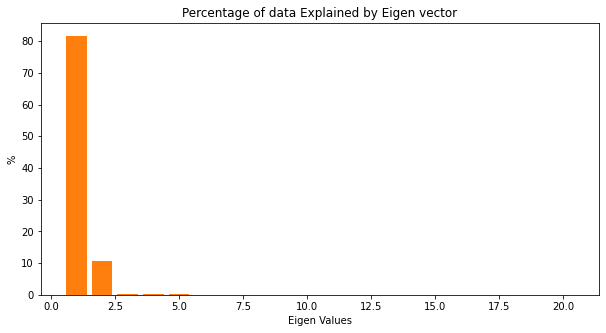

In [16]:
full_pca_img, partial_pca_img, mask, _, _, PCA_orig, PCA = load_and_process_fc(path_list[0],number_principal_components,img_percentage)

is_test = False

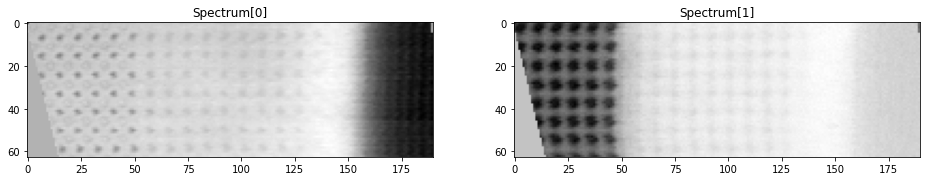

In [9]:
f = plot_spectre(full_pca_img)

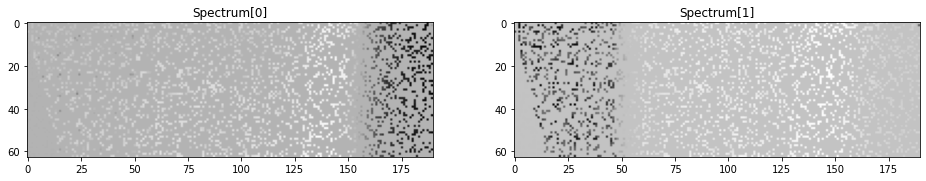

In [10]:
f = plot_spectre(partial_pca_img)

## Plane image (training)

In [75]:
full_pca_img, img_rgb, partial_pca_img, mask, PCA_orig, PCA = load_aviris(img_percentage, do_pca, number_principal_components)

is_test = False

Image loaded with success !
RGB-Image created with success !
Mask created with success !
Both PCA done with success !


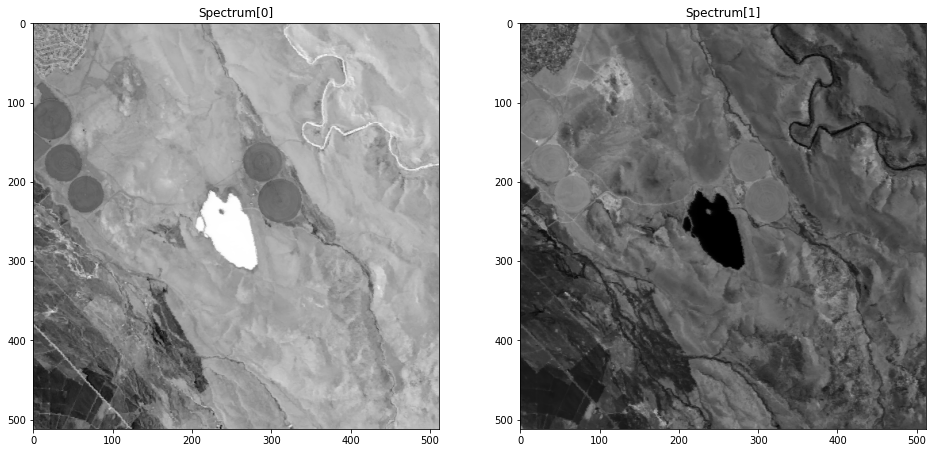

In [76]:
f = plot_spectre(full_pca_img)

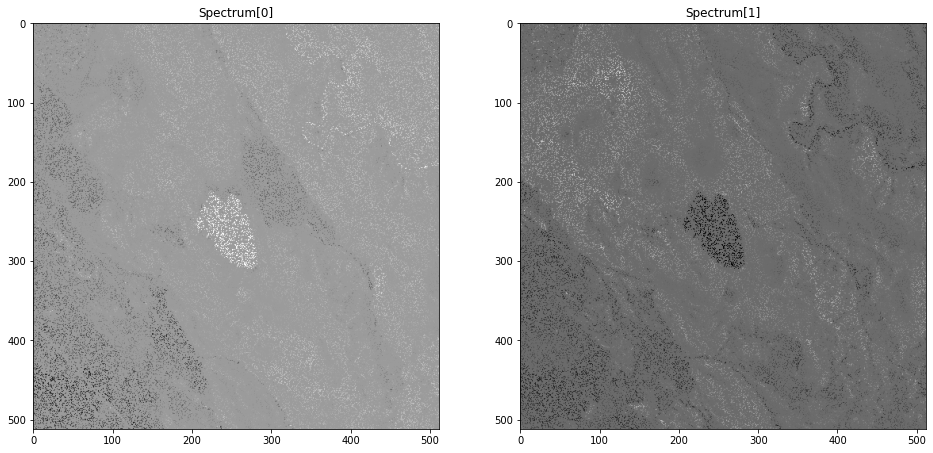

In [77]:
f = plot_spectre(partial_pca_img)

## Test data

In [0]:
test_img, partial_pca_img, mask, PCA = load_and_process_test_image(number_principal_components)

is_test = True

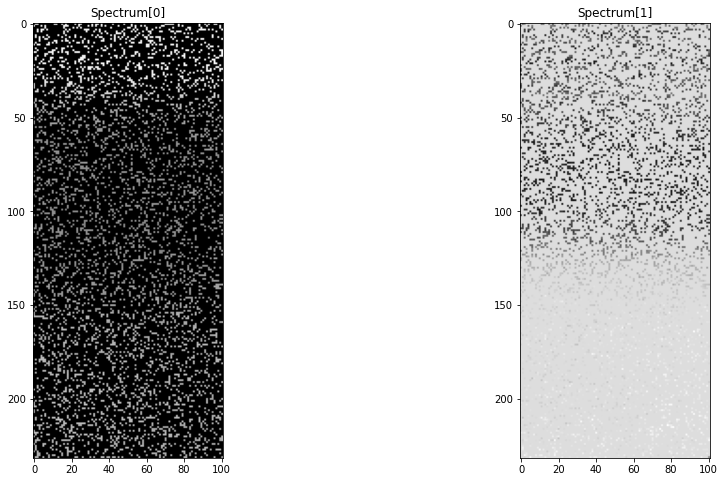

In [22]:
f = plot_spectre(partial_pca_img)

#Training

In [0]:
input_depth = partial_pca_img.shape[0]
output_depth = partial_pca_img.shape[0]

## Hyperparameters

In [0]:
num_iter = 3001
show_every = 100
reg_noise_std = 0.01

loss_name = 'master_metric' # one of 'mse'|'master_metric'
NET_TYPE = 'resnet' # one of skip_depth4|skip_depth2|resnet
OPTIMIZER = 'adamw' # one of 'adam'|'adamw'
pad = 'zero' 

LR = 0.01

grad_clipping = True # True or False

resnet_num_blocks = 8
resnet_num_channels = 32

Feel free to tweak some parameters below.

In [0]:
if 'skip' in NET_TYPE:
    
    depth = int(NET_TYPE[-1])
    net = skip(input_depth, output_depth, 
            num_channels_down = [64, 64, 64][:depth],
            num_channels_up =   [64, 64, 64][:depth],
            num_channels_skip =    [16, 16, 16][:depth],  
            filter_size_up = 5,filter_size_down = 5,  filter_skip_size=1,
            upsample_mode='nearest', # downsample_mode='avg',
            need1x1_up=False,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif NET_TYPE == 'resnet':
    
    net = ResNet(input_depth, output_depth, resnet_num_blocks, resnet_num_channels, act_fun='LeakyReLU')

else:
    raise ValueError("Select an architecture among skip_depth6 | skip_depth4 skip_depth2 | resnet")

## Let's go

In [0]:
(ssim, psnr, sad), time_elapsed, out_np = train(net, partial_pca_img, mask, OPTIMIZER, loss_name, num_iter, grad_clipping, LR, reg_noise_std, show_every)

In [0]:
if is_test:
    restored = results(out_np, time_elapsed, PCA, is_test=is_test)
    print('Restored Summed Image')
    plt.imshow(restored)
if not is_test:
    restored , orig = results(out_np, time_elapsed, PCA, is_test=is_test)
    print('Restored Summed Image')
    plt.imshow(restored)

In [0]:
if not is_test
    print('Original Summed Image')
    plt.imshow(orig)